# Comparison of surface water mass transformation in MOM6

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from collections import OrderedDict
from dask.distributed import Client
import cftime
from datetime import timedelta
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
import matplotlib.path as mpath

import matplotlib.pyplot as plt
import cmocean.cm as cmo
import matplotlib.colors as col

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39937,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:35141,Total threads: 6
Dashboard: /proxy/33747/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:43435,


## Load data

In [4]:
session = cc.database.create_session()

path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

In [5]:
exptdict = OrderedDict([
    ('pa_z_v13', # 1/10th panantarctic zstar run
     {'expt': 'panant-01-zstar-v13'}),
    ('pa_h_v13', # 1/10th panantarctic hybrid run
     {'expt': 'panant-01-hycom1-v13'}),
    ('pa_z_yr2', # 1/10th panantarctic zstar run with ACCESS-OM2-01 year IC + BF
     {'expt': 'panant-01-zstar-ACCESSyr2'}),
    ('gl_z_v2', # 1/10th global zstar run version 2
     {'expt': 'global-01-v2'}),
    ('gl_z_v3', # 1/10th global zstar run version 3
     {'expt': 'global-01-v3'})
])

In [6]:
%%time
ekeys = ['pa_z_v13', 'pa_h_v13', 'pa_z_yr2', 'gl_z_v2', 'gl_z_v3']
for ekey in ekeys:
    e = exptdict[ekey]
    
    ds_SWMT_DSW = xr.open_mfdataset(
        path_output + 'SWMT_in_DSW_region_' + e['expt']  + '*.nc')
    e['swmt_DSW'] = (
        ds_SWMT_DSW.binned_salt_transformation_in_DSW_region +
        ds_SWMT_DSW.binned_heat_transformation_in_DSW_region).compute()
    
    ds_SWMT = xr.open_mfdataset(
        path_output + 'SWMT_' + e['expt'] + '_mean_*.nc')
    e['swmt'] = (ds_SWMT.binned_salt_transformation +
                 ds_SWMT.binned_heat_transformation)

CPU times: user 12.9 s, sys: 5.82 s, total: 18.7 s
Wall time: 1min 3s


## Functions for plotting

In [7]:
def plot_swmt_in_DSW_region(ekeys, time_slice=None):
    
    for i, ekey in enumerate(ekeys):
        e = exptdict[ekey]
        if time_slice is None:
            swmt = e['swmt_DSW']
        else:
            swmt = e['swmt_DSW'].sel(time=time_slice)
        
        plt.subplot(3, 2, i+1)
        for a in range(4):
            plt.plot(
                swmt.mean('time')[:, a],
                swmt.isopycnal_bins,
                label=swmt.area[a].values)
        plt.xlim(-.2, 2.2)
        plt.ylim(32.9, 31.9)
        
        plt.legend()

        plt.xlabel('Surface water mass transformation (Sv)')
        plt.ylabel('Potential density $\sigma_1\,$(kg$\,$m$^{-3}$)')
        plt.title(e['expt'] + ' (mean ' + str(swmt.time.min().values) +
                  '-' + str(swmt.time.max().values) + ')', fontweight='bold')

In [8]:
def plot_swmt_in_each_DSW_region(ekeys, time_slice=None):
    
    for a in range(4):
        plt.subplot(2, 2, a+1)
        for i, ekey in enumerate(ekeys):
            e = exptdict[ekey]
            if time_slice is None:
                swmt = e['swmt_DSW']
            else:
                swmt = e['swmt_DSW'].sel(time=time_slice)

            plt.plot(
                swmt.mean('time')[:, a],
                swmt.isopycnal_bins,
                label=e['expt'])
        plt.xlim(-.2, 2.2)
        plt.ylim(32.9, 31.9)

        plt.legend()

        plt.xlabel('Surface water mass transformation (Sv)')
        plt.ylabel('Potential density $\sigma_1\,$(kg$\,$m$^{-3}$)')
        plt.title(str(swmt.area[a].values) + ' (mean ' + str(swmt.time.min().values) +
                  '-' + str(swmt.time.max().values) + ')', fontweight='bold')

In [9]:
def lines_colored_by_cmap(parameter_to_color, cmap):
    # normalize data into the [0.0, 1.0] interval.
    norm = col.Normalize(
        vmin=np.min(parameter_to_color),
        vmax=np.max(parameter_to_color))

    # create a ScalarMappable and initialize a data structure
    s_m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    return s_m   

In [10]:
def plot_swmt_in_each_DSW_region_each_year(expt, time_slice=None):
    e = exptdict[expt]
    if time_slice is None:
        swmt = e['swmt_DSW']
    else:
        swmt = e['swmt_DSW'].sel(time=time_slice)
        
    s_m = lines_colored_by_cmap(
        parameter_to_color=swmt.time, cmap=cmo.haline)

    for a in range(4):
        # maximum SWMT of time mean 
        swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = swmt.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
        
        plt.subplot(2, 2, a+1)
        for n in range(len(swmt.time)):
            plt.plot(
                swmt[n, :, a], swmt.isopycnal_bins,
                color=s_m.to_rgba(swmt.time[n]))
        cb = plt.colorbar(s_m, orientation='horizontal')
        plt.plot(
            swmt.mean('time')[:, a], swmt.isopycnal_bins,
            color='r', linewidth=2, label=('mean ' + str(swmt.time.min().values) +
                  '-' + str(swmt.time.max().values)))
        plt.axhline(swmt_sig_bin.values, color='grey')
        plt.legend()
        plt.xlim(-.2, 2.2)
        plt.ylim(32.9, 31.9)

        # plt.legend()

        plt.xlabel('Surface water mass transformation (Sv)')
        plt.ylabel('Potential density $\sigma_1\,$(kg$\,$m$^{-3}$)')
        plt.title(str(swmt.area[a].values) + ' in ' + e['expt'], fontweight='bold')

In [17]:
def plot_swmt_timeseries_max_vs_70(expt):
    e = exptdict[expt]
    swmt = e['swmt_DSW']
    
    for a in range(4):
        # maximum SWMT of time mean 
        swmt_max = swmt.mean('time')[swmt.mean('time')[:, a].argmax(
            'isopycnal_bins').values, a]
        # isopycnal bin corresponding to SWMT 70% below its maximum value
        swmt_sig_bin = swmt.isopycnal_bins.sel(
            isopycnal_bins=slice(swmt_max.isopycnal_bins, None)).where(
            swmt.mean('time')[:, a] < swmt_max*.7).min('isopycnal_bins')
    
        plt.subplot(4, 1, a+1)
        swmt[:, :, a].max('isopycnal_bins').plot(label='maximum each year')
        swmt[:, :, a].sel(isopycnal_bins=swmt_sig_bin, method='nearest').plot(
            label=(r'same $\sigma_1$ (at 70% of SWMT peak)'))
        plt.ylim(0, 2.5)
        if a == 0:
            plt.legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 1.2))
        plt.autoscale(enable=True, axis='x', tight=True)
        if a < 3:
            plt.gca().set_xticklabels([])
        plt.xlabel('')
        plt.title('')
        plt.text(.01, .05, str(swmt.area[a].values), fontweight='bold',
                 transform=plt.gca().transAxes)
        plt.text(.13, .05, r'$\sigma_1$=' + str(np.round(swmt_sig_bin.values, 2)),
                 color='tab:orange', transform=plt.gca().transAxes)

## Plots

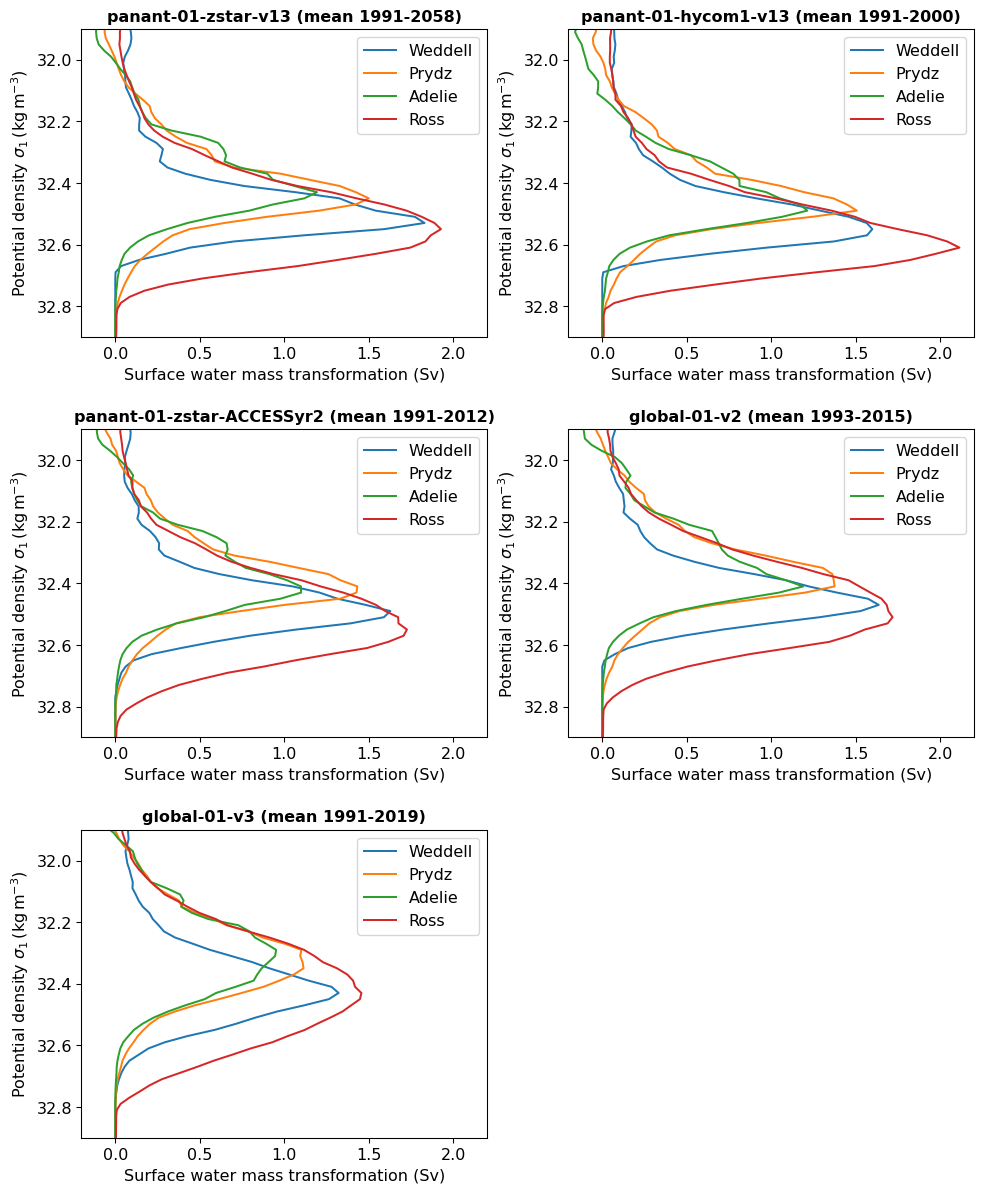

In [11]:
fig = plt.figure(figsize=(12, 15))
plt.subplots_adjust(hspace=.3)
plot_swmt_in_DSW_region(ekeys)

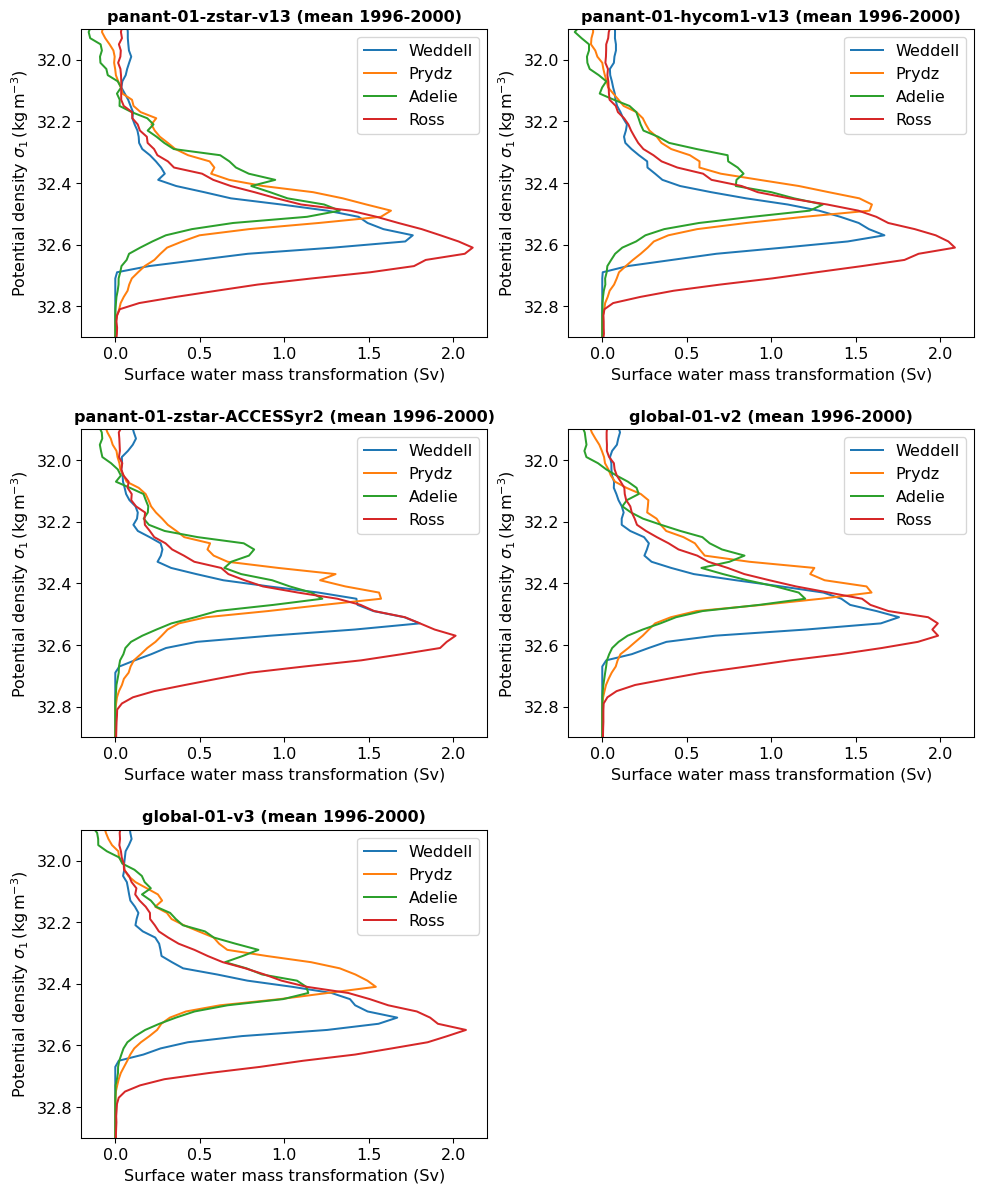

In [12]:
fig = plt.figure(figsize=(12, 15))
plt.subplots_adjust(hspace=.3)
plot_swmt_in_DSW_region(ekeys, time_slice=slice('1996', '2000'))

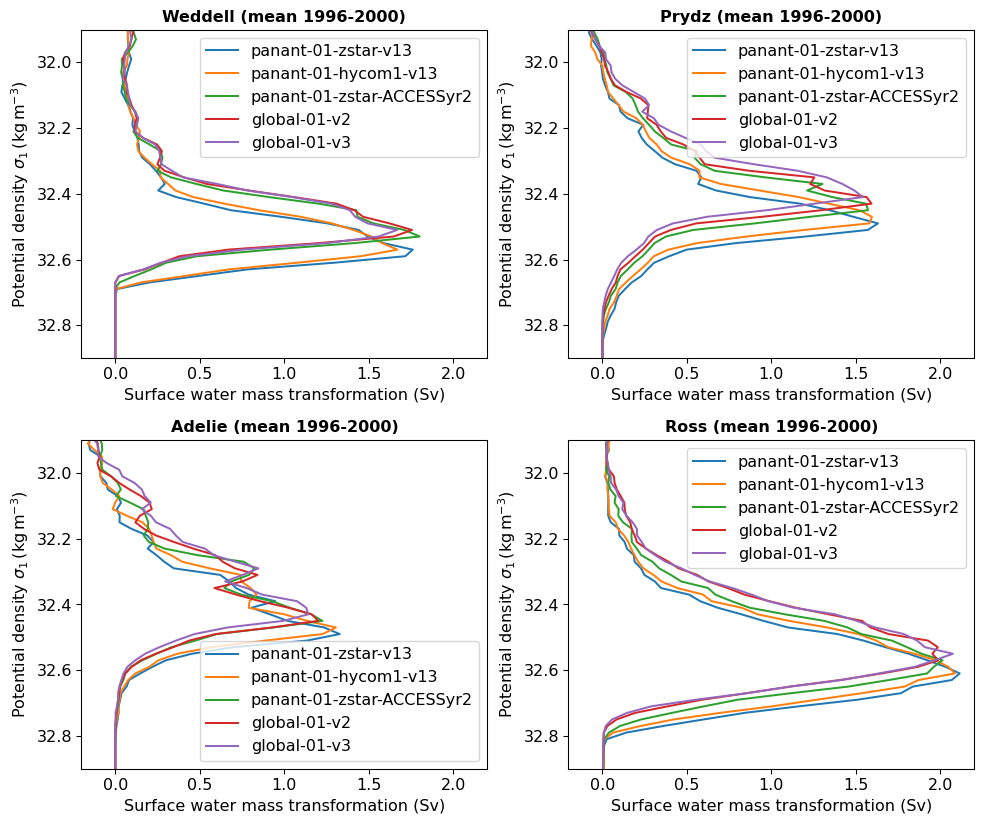

In [13]:
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=.25)
plot_swmt_in_each_DSW_region(ekeys, time_slice=slice('1996', '2000'))

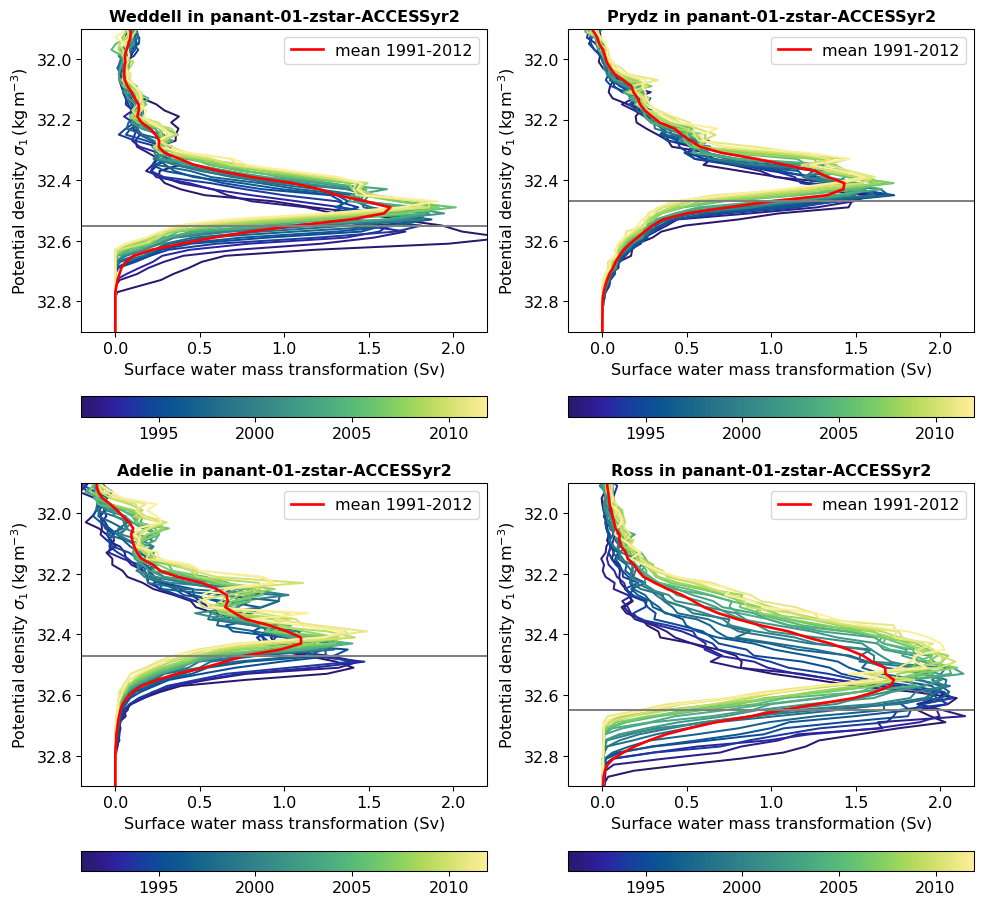

In [14]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.05)

expt = 'pa_z_yr2'
plot_swmt_in_each_DSW_region_each_year(expt)


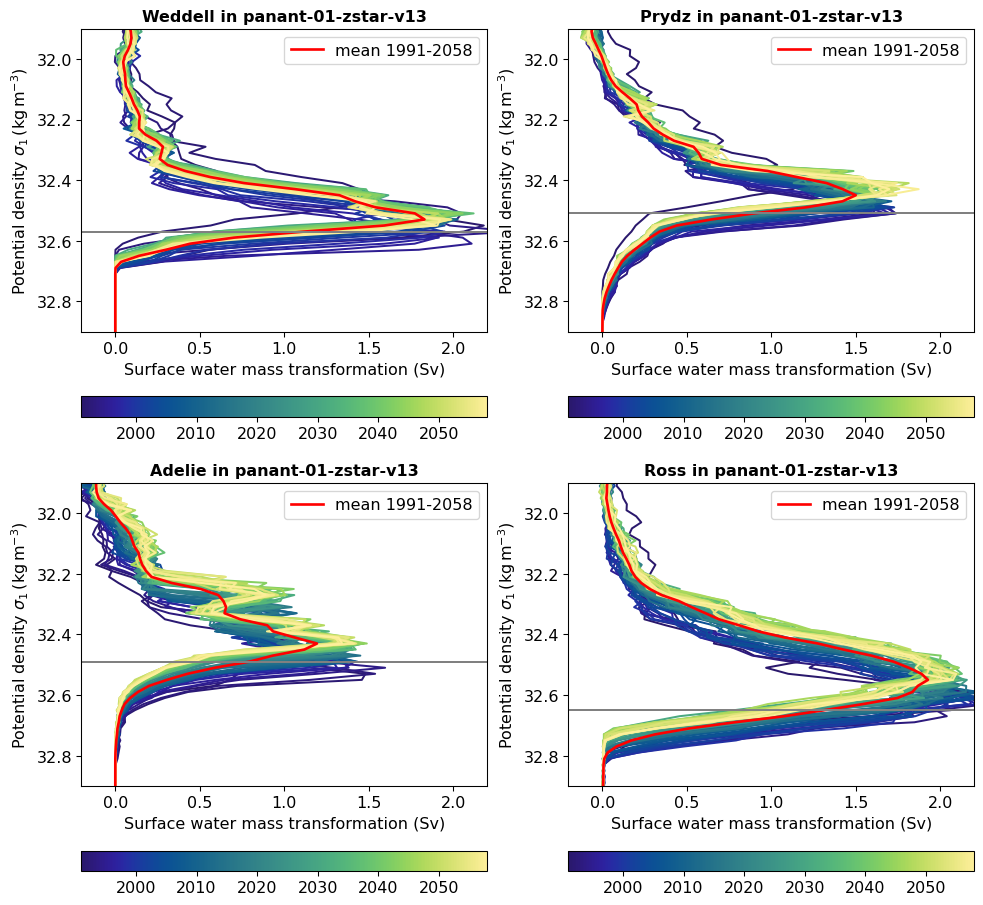

In [15]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.05)

expt = 'pa_z_v13'
plot_swmt_in_each_DSW_region_each_year(expt)


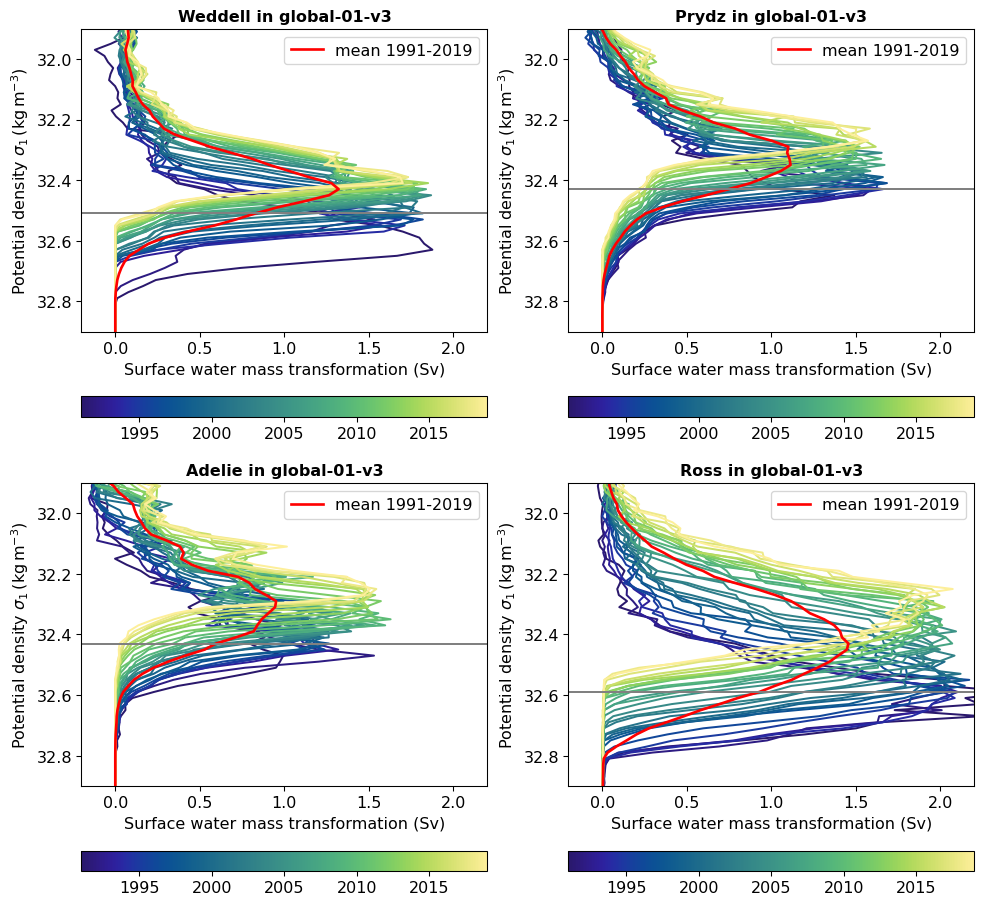

In [16]:
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=.05)

expt = 'gl_z_v3'
plot_swmt_in_each_DSW_region_each_year(expt)


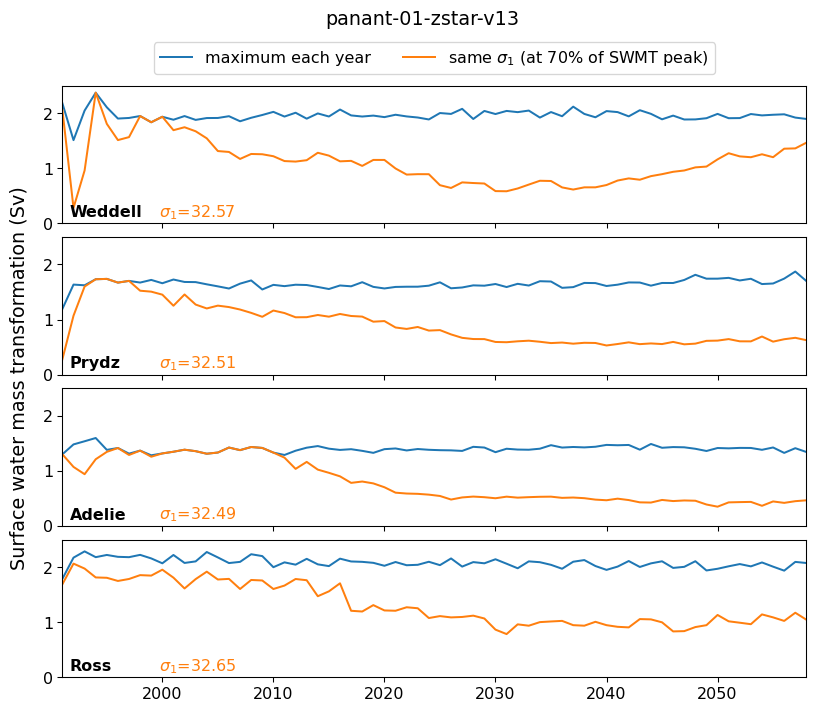

In [18]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.1)
expt = 'pa_z_v13'
plot_swmt_timeseries_max_vs_70(expt)
fig.supylabel('Surface water mass transformation (Sv)', x=.07)
fig.suptitle(exptdict['pa_z_v13']['expt'])
plt.show()

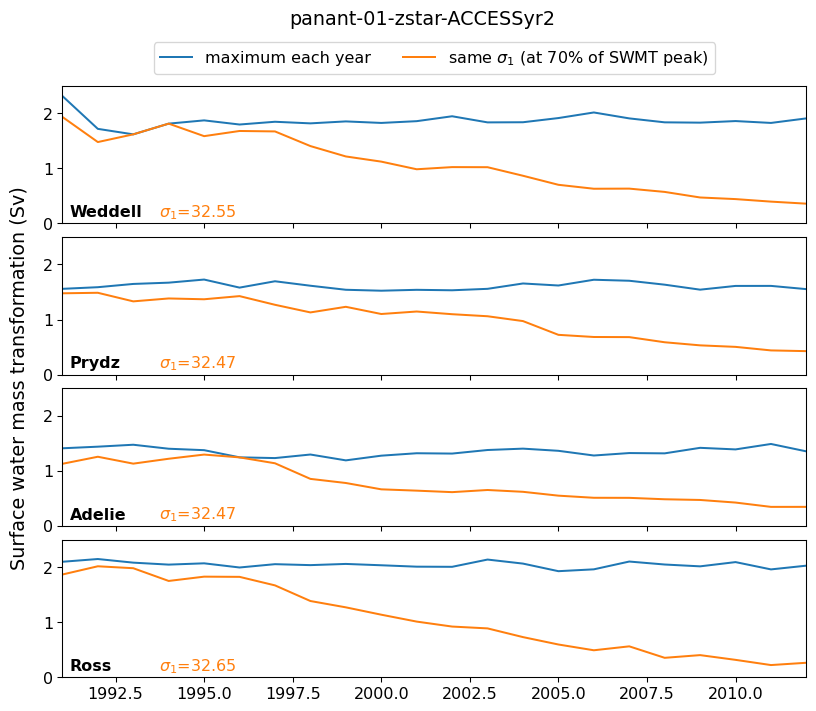

In [19]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.1)
expt = 'pa_z_yr2'
plot_swmt_timeseries_max_vs_70(expt)
fig.supylabel('Surface water mass transformation (Sv)', x=.07)
fig.suptitle(exptdict[expt]['expt'])
plt.show()

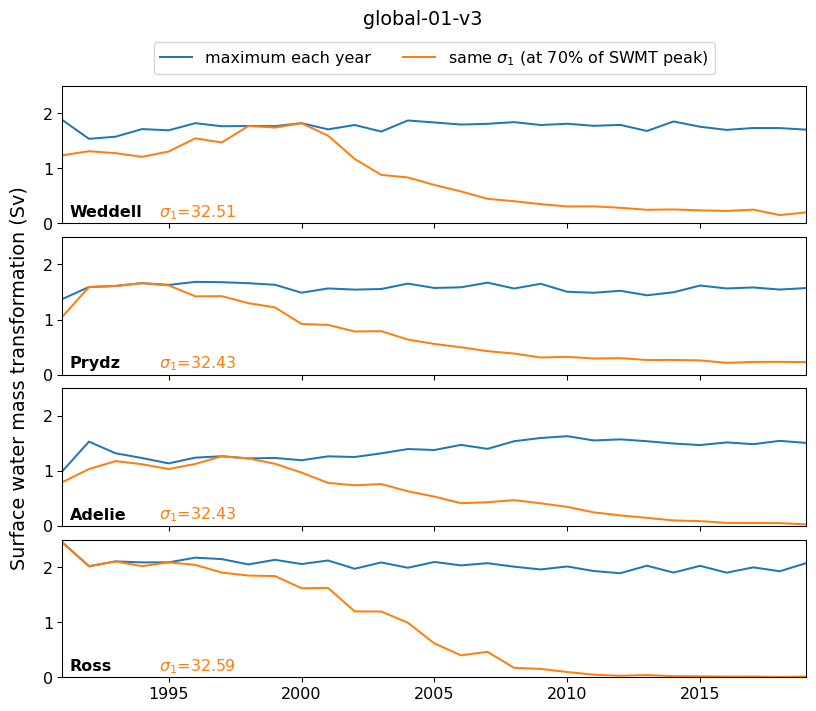

In [20]:
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=.1)
expt = 'gl_z_v3'
plot_swmt_timeseries_max_vs_70(expt)
fig.supylabel('Surface water mass transformation (Sv)', x=.07)
fig.suptitle(exptdict[expt]['expt'])
plt.show()

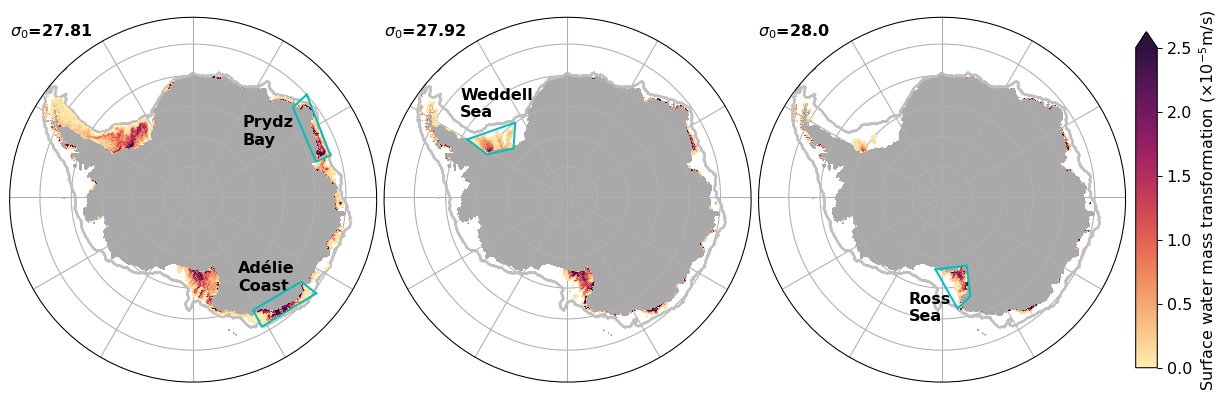

In [42]:
fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.02)
padx, pady, width = (0.007, .03, 0.015)

for n, a in enumerate([0, 1, 3]):
    ax = plt.subplot(1, 3, n, projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

    
    # to do
    # land mask
    # 1000-m isobath
    
    ax.contourf(land_mask.xt_ocean.values,
                np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
                land_mask, colors='darkgrey', levels=[0.5, 2],
                transform=ccrs.PlateCarree(), rasterized=True, zorder=2)
    plt.plot(tracer_1000m.lon, tracer_1000m.lat, '.', color='silver', markersize=.5,
             transform=ccrs.PlateCarree())

    p1 = ax.pcolormesh(
        xt_ocean, yt_ocean, swmt_shelf[a, :, :]*1e5, vmin=0, vmax=2.5,
        cmap=cmo.matter, transform=ccrs.PlateCarree(), rasterized=True, zorder=3)
    
    plt.plot(DSW_region['lon'][a], DSW_region['lat'][a], 'c',
             transform=ccrs.PlateCarree(), zorder=4)
    if a == 1:
        plt.plot(DSW_region['lon'][2], DSW_region['lat'][2], 'c',
                 transform=ccrs.PlateCarree(), zorder=4)
        
    ax.text(0, 0.95, (r'$\sigma_{0}$=' + str(
        swmt_shelf[a, :, :].isopycnal_bins.round(2).values)),
            fontweight='bold', transform=ax.transAxes)
    
    if a == 0:
        plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=ccrs.PlateCarree())
    elif a == 1:
        plt.text(43, -78, 'Prydz\nBay', fontweight='bold', transform=ccrs.PlateCarree())
        plt.text(154, -73, 'Adélie\nCoast', fontweight='bold', transform=ccrs.PlateCarree())
    elif a == 3:
        plt.text(-165, -69, 'Ross\nSea', fontweight='bold', transform=ccrs.PlateCarree())

pos = ax.get_position()
cax = plt.axes([pos.xmax+padx, pos.ymin+pady, width, (pos.ymax-pos.ymin)-2*pady])
cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='max')
cb.ax.set_ylabel(r'Surface water mass transformation ($\times 10^{-5}$m/s)')

if savefigures is True:
    plt.savefig(
        path_Plots + ('SWMT_maps_time_mean_for_sig0_of_area_' + expt + '_' + frequency[0:3:2] + '_' +
                      str(year_all[0]) + '-' + str(year_all[-1]) + '.png'),
        dpi=300, bbox_inches="tight")
plt.show()

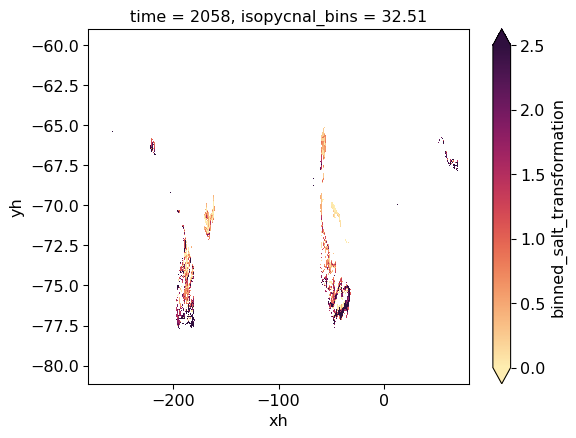

In [8]:
(1e5*ds_SWMT.binned_salt_transformation.sel(isopycnal_bins=32.5, method='nearest'))[-1, :].plot(
    vmin=0, vmax=2.5, cmap=cmo.matter)

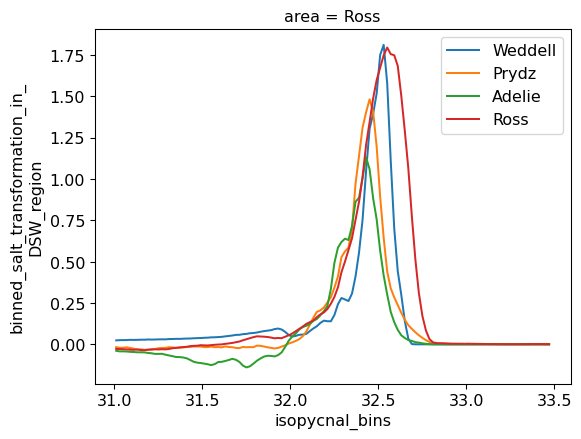

In [9]:
for a in range(4):
    ds_SWMT_regions.binned_salt_transformation_in_DSW_region.mean('time')[:, a].plot(
        label=ds_SWMT_regions.area[a].values)
plt.legend()